Additional Information (Dicoding Profile):

- User profile:
 - Full name: Aditya Dwi Nugraha
 - Username: aditya_dwi_10
 - Email: adityadwinugraha.2021@gmail.com

Submission/Project has been completed with all requirements.

Final Project: Image Classification (Klasifikasi Gambar)

Class: Belajar Pengembangan Machine Learning

Image Classification: Fruits

Created by: Aditya Dwi Nugraha

© Copyright 2025 All Right Reserved by Aditya Dwi Nugraha

## Install Requirements

In [ ]:
%pip install -U pandas numpy==1.20.0 matplotlib tensorflow keras colabcode opencv-python kaggle scipy tensorflowjs IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


## Import Semua Packages/Library yang Digunakan

In [ ]:
import os
import ssl
import cv2
import json
import time
import zipfile
import requests

import shutil
import pickle
import numpy as np
import urllib.request
from tqdm import tqdm
from io import BytesIO

from google.colab import files
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

## Data Preparation

### Data Loading

Mengunduh dataset

In [ ]:
# Membuat folder dataset jika tidak ada
[os.makedirs(f"/content/{dir}", exist_ok=True) for dir in ["dataset", "download"]]

# Mendownload dataset untuk klasifikasi
!kaggle datasets download -d swoyam2609/fresh-and-stale-classification -p ./

# Mengekstrak file zip ke folder dataset
!unzip -n fresh-and-stale-classification.zip -d ./


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: ./dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_5372.jpg  
  inflating: ./dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_54.jpg  
  inflating: ./dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6186.jpg  
  inflating: ./dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6285.jpg  
  inflating: ./dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6551.jpg  
  inflating: ./dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6565.jpg  
  inflating: ./dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6985.jpg  
  inflating: ./dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_7173.jpg  
  inflating: ./dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_7306.jpg  
  inflating: ./dataset/Tr

### Data Preprocessing

#### Hanya menyimpan dataset yang ada di variable include_label serta menghapus latar belakangnya

In [ ]:
# [os.system(f"rm -rf dataset/{dir}") for dir in ['_train_', '_test_']] # Menghapus folder dataset

In [ ]:
def remove_bg(image_path, output_path, threshold=240):
    img = Image.open(image_path).convert("RGBA")
    datas = img.getdata()
    newData = []

    for item in datas:
        if item[0] >= threshold and item[1] >= threshold and item[2] >= threshold: newData.append((255, 255, 255, 0))
        else: newData.append(item)

    img.putdata(newData)

    img.save(output_path, "PNG")

include_label = [
    "Fresh Apples",
    "Fresh Banana",
    "Rotten Apples",
    "Rotten Banana"
]

def process_directory(dir_path, label, output_dir):
    if label not in include_label: return label

    for root, dirs, files in os.walk(dir_path):
        relative_path = os.path.relpath(root, dir_path)
        out_dir = os.path.join(output_dir, relative_path, label)
        os.makedirs(out_dir, exist_ok=True)

        print("Processed:", out_dir)

        for file in tqdm(files):
            image_path = os.path.join(root, file)
            output_filename = os.path.splitext(os.path.basename(file))[0] + ".png"
            output_path = os.path.join(out_dir, output_filename)

            if not os.path.exists(output_path): remove_bg(image_path, output_path)

        print("")

dataset_path = "./dataset"

train_dataset_path = os.path.join("dataset", "_train_")
test_dataset_path = os.path.join("dataset", "_test_")

try:
    for folder in os.listdir(train_dataset_path):
        folder_path = os.path.join(train_dataset_path, folder)
        if os.path.isdir(folder_path) and folder not in include_label:
            print(f"Menghapus folder (train): {folder_path}")
except Exception as e: pass

try:
    for folder in os.listdir(test_dataset_path):
        folder_path = os.path.join(test_dataset_path, folder)
        if os.path.isdir(folder_path) and folder not in include_label:
            print(f"Menghapus folder (test): {folder_path}")
except Exception as e: pass

list_process = {
    'Train': [],
    'Test': []
}

for dir in os.listdir(dataset_path):
    dir_path = os.path.join(dataset_path, dir)
    if dir in ["Train", "Test"]:
        for label in sorted(os.listdir(dir_path)):
            try:
                old_path = os.path.join(dir_path, label)

                new_label = "Fresh " + label.split("fresh", 1)[1].strip().capitalize() if "fresh" in label else "Rotten " + label.split("rotten", 1)[1].strip().capitalize()

                new_path = os.path.join(dir_path, new_label)

                os.rename(old_path, new_path)
            except Exception as e:
                new_label = label
                new_path = os.path.join(dir_path, new_label)

            if new_label in include_label: list_process[dir].append(new_path)

print(list_process)

for dir in list_process:
    for new_path in list_process[dir]:
        label = new_path.split("/")[-1]
        process_directory(new_path, label, train_dataset_path if dir == "Train" else test_dataset_path)

{'Train': ['./dataset/Train/Fresh Apples', './dataset/Train/Fresh Banana', './dataset/Train/Rotten Apples', './dataset/Train/Rotten Banana'], 'Test': ['./dataset/Test/Fresh Apples', './dataset/Test/Fresh Banana', './dataset/Test/Rotten Apples', './dataset/Test/Rotten Banana']}
Processed: dataset/_train_/./Fresh Apples


100%|██████████| 2424/2424 [00:00<00:00, 137384.37it/s]



Processed: dataset/_train_/./Fresh Banana


100%|██████████| 2468/2468 [05:21<00:00,  7.67it/s]



Processed: dataset/_train_/./Rotten Apples


100%|██████████| 3248/3248 [06:01<00:00,  8.99it/s]



Processed: dataset/_train_/./Rotten Banana


100%|██████████| 2932/2932 [06:48<00:00,  7.17it/s]



Processed: dataset/_test_/./Fresh Apples


100%|██████████| 791/791 [01:05<00:00, 12.16it/s]



Processed: dataset/_test_/./Fresh Banana


100%|██████████| 892/892 [01:59<00:00,  7.48it/s]



Processed: dataset/_test_/./Rotten Apples


100%|██████████| 988/988 [01:51<00:00,  8.87it/s]



Processed: dataset/_test_/./Rotten Banana


100%|██████████| 900/900 [02:07<00:00,  7.06it/s]

#### Cek ukuran masing-masing dataset rentang 3-9

In [ ]:
for dir in os.listdir(dataset_path):
    dir_path = os.path.join(dataset_path, dir)
    if dir in ["_train_", "_test_"]:
        for subdir in sorted(os.listdir(dir_path)):
            all_files = []

            for root, dirs, files in os.walk(os.path.join(dir_path, subdir)):
                for file in files:
                    file_path = os.path.join(root, file)
                    all_files.append(file_path)

            if all_files:
                n_random = np.random.randint(3, 10)
                if len(all_files) < n_random: n_random = len(all_files)
                random_files = np.random.choice(all_files, size=n_random, replace=False)

                print(f"Memilih {n_random} gambar secara acak:")
                for file_path in random_files:
                    try: print(f"{file_path}: {Image.open(file_path).size}")
                    except Exception as e: print(f"Error membuka {file_path}: {e}")
            else: print("Tidak ada file gambar yang ditemukan.")

            print("")


Memilih 3 gambar secara acak:
./dataset/_train_/Fresh Apples/rotated_by_45_Screen Shot 2018-06-08 at 5.28.48 PM.png: (168, 158)
./dataset/_train_/Fresh Apples/saltandpepper_Screen Shot 2018-06-08 at 5.25.22 PM.png: (274, 316)
./dataset/_train_/Fresh Apples/saltandpepper_Screen Shot 2018-06-08 at 5.16.49 PM.png: (442, 398)

Memilih 5 gambar secara acak:
./dataset/_train_/Fresh Banana/b_f529.png: (644, 384)
./dataset/_train_/Fresh Banana/rotated_by_45_Screen Shot 2018-06-12 at 9.41.30 PM.png: (460, 398)
./dataset/_train_/Fresh Banana/b_f828.png: (486, 478)
./dataset/_train_/Fresh Banana/b_f175.png: (528, 350)
./dataset/_train_/Fresh Banana/translation_Screen Shot 2018-06-12 at 10.06.12 PM.png: (332, 386)

Memilih 9 gambar secara acak:
./dataset/_train_/Rotten Apples/rotated_by_45_Screen Shot 2018-06-07 at 2.19.37 PM.png: (392, 372)
./dataset/_train_/Rotten Apples/Screen Shot 2018-06-07 at 2.44.26 PM.png: (340, 352)
./dataset/_train_/Rotten Apples/rotated_by_60_Screen Shot 2018-06-07 at 2

#### Memeriksa file yang korup dataset pada folder test dan menghapusnya

In [ ]:
list_file_corrupt = []

In [ ]:
def validate_test_images(test_dir):
    if not list_file_corrupt:
        for root, dirs, files in os.walk(test_dir):
            for file in files:
                file_path = os.path.join(root, file)
                try: Image.open(file_path).verify()
                except Exception as e: list_file_corrupt.append([file_path, e])

validate_test_images(test_dataset_path)
[print(f"File {file_path} tidak valid: {e}") for (file_path, e) in list_file_corrupt]
print("\nJumlah file test yang tidak valid:", len(list_file_corrupt), "\n")

for (path, e) in list_file_corrupt:
    print(f"Menghapus file {path}")
    try: os.remove(path)
    except: pass

File dataset/_test_/Fresh Apples/translation_Screen Shot 2018-06-08 at 5.27.19 PM.png tidak valid: truncated PNG file
File dataset/_test_/Fresh Apples/a_f157.png tidak valid: cannot identify image file 'dataset/_test_/Fresh Apples/a_f157.png'
File dataset/_test_/Fresh Apples/rotated_by_60_Screen Shot 2018-06-08 at 5.11.52 PM.png tidak valid: cannot identify image file 'dataset/_test_/Fresh Apples/rotated_by_60_Screen Shot 2018-06-08 at 5.11.52 PM.png'
File dataset/_test_/Fresh Apples/rotated_by_75_Screen Shot 2018-06-08 at 5.18.16 PM.png tidak valid: cannot identify image file 'dataset/_test_/Fresh Apples/rotated_by_75_Screen Shot 2018-06-08 at 5.18.16 PM.png'

Jumlah file test yang tidak valid: 4 

Menghapus file dataset/_test_/Fresh Apples/translation_Screen Shot 2018-06-08 at 5.27.19 PM.png
Menghapus file dataset/_test_/Fresh Apples/a_f157.png
Menghapus file dataset/_test_/Fresh Apples/rotated_by_60_Screen Shot 2018-06-08 at 5.11.52 PM.png
Menghapus file dataset/_test_/Fresh Apples/

In [ ]:
def zip_train_test(dataset_path="./dataset", folders_to_zip=["_train_", "_test_"], zip_filename="dataset_train_test.zip"):
    """
    Membuat file ZIP berisi hanya subfolder yang ditentukan (folders_to_zip)
    dari folder dataset_path (default: ./dataset).
    """
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for folder_name in folders_to_zip:
            folder_path = os.path.join(dataset_path, folder_name)
            if os.path.isdir(folder_path):
                # Telusuri seluruh file dalam folder_path
                for root, dirs, files in os.walk(folder_path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        # Tentukan nama file di dalam arsip (arcname) relatif terhadap dataset_path
                        arcname = os.path.relpath(file_path, dataset_path)
                        zipf.write(file_path, arcname=arcname)
    print(f"File ZIP '{zip_filename}' telah berhasil dibuat.")

# Contoh penggunaan
zip_train_test(
    dataset_path="./dataset",
    folders_to_zip=["_train_", "_test_"],
    zip_filename="train_test_dataset.zip"
)

# files.download("train_test_dataset.zip")

File ZIP 'train_test_dataset.zip' telah berhasil dibuat.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Inisialisasi ImageDataGenerator

In [ ]:
image_size = (100, 100)
batch_size = 256

Inisialisasi ImageDataGenerator untuk data train dan validation menggunakan file transparan

In [ ]:
# Initialize ImageDataGenerator for train and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,

    # Karena dataset sudah mengalami processing
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
)

# Create train generator
train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='rgba',
    shuffle=True
) # Found 8860 images belonging to 4 classes.

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='rgba',
    shuffle=True
) # Found 2212 images belonging to 4 classes.

print(train_datagen)
print(train_generator)
print(validation_generator)

# Tentukan jumlah kelas dari training generator
num_label = len(train_generator.class_indices)

print("\nNum classes:", num_label)

Found 8860 images belonging to 4 classes.
Found 2212 images belonging to 4 classes.

Num classes: 4


Inisialisasi ImageDataGenerator untuk data test menggunakan file transparan

In [ ]:
# Initialize ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgba',
    shuffle=False,
    classes=include_label
) # Found 4050 images belonging to 4 classes.

print(test_datagen)
print(test_generator)

Found 4050 images belonging to 4 classes.


#### Memvisualisasikan file setiap class

In [ ]:
def visualize_images(images, labels, num_rows=5, num_cols=5):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(min(len(images), num_rows*num_cols)):
        axs[i].set_facecolor('gray')
        axs[i].imshow(images[i])
        axs[i].set_title(labels[i])
        axs[i].axis('off')

    fig.patch.set_facecolor('gray')

    plt.tight_layout()
    plt.show()

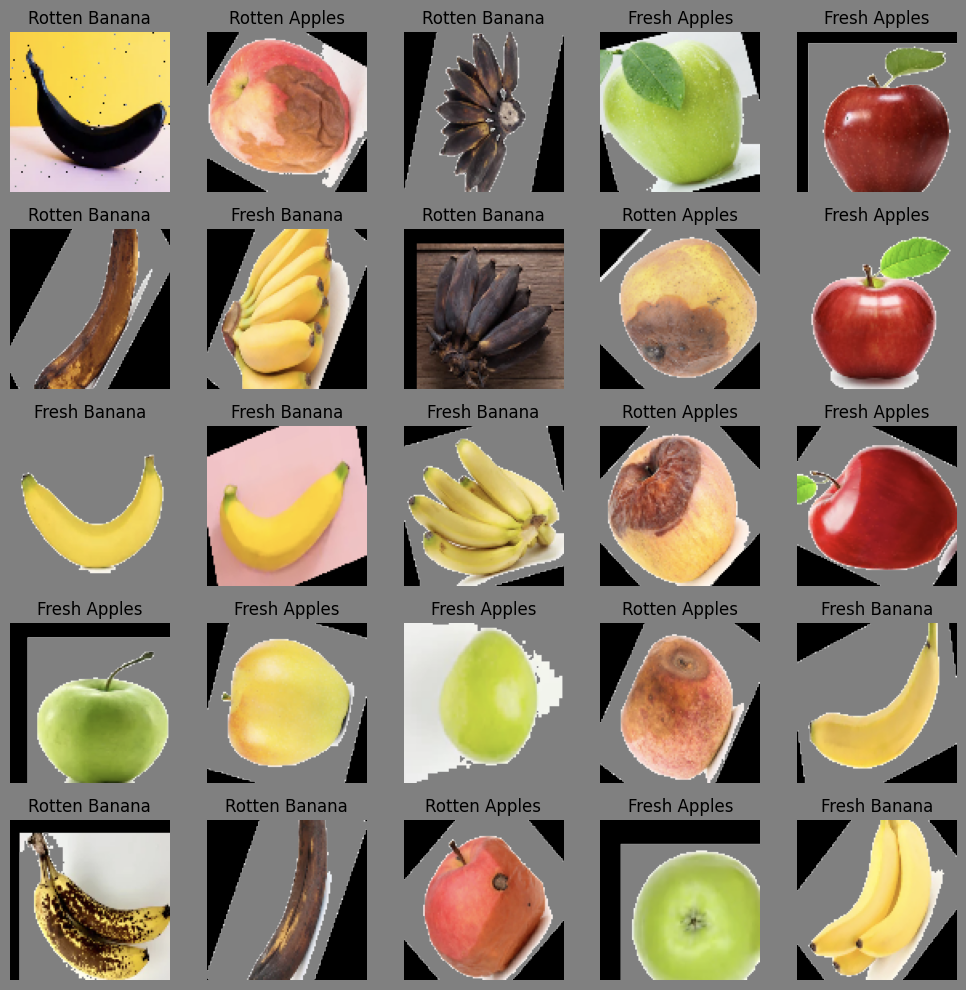

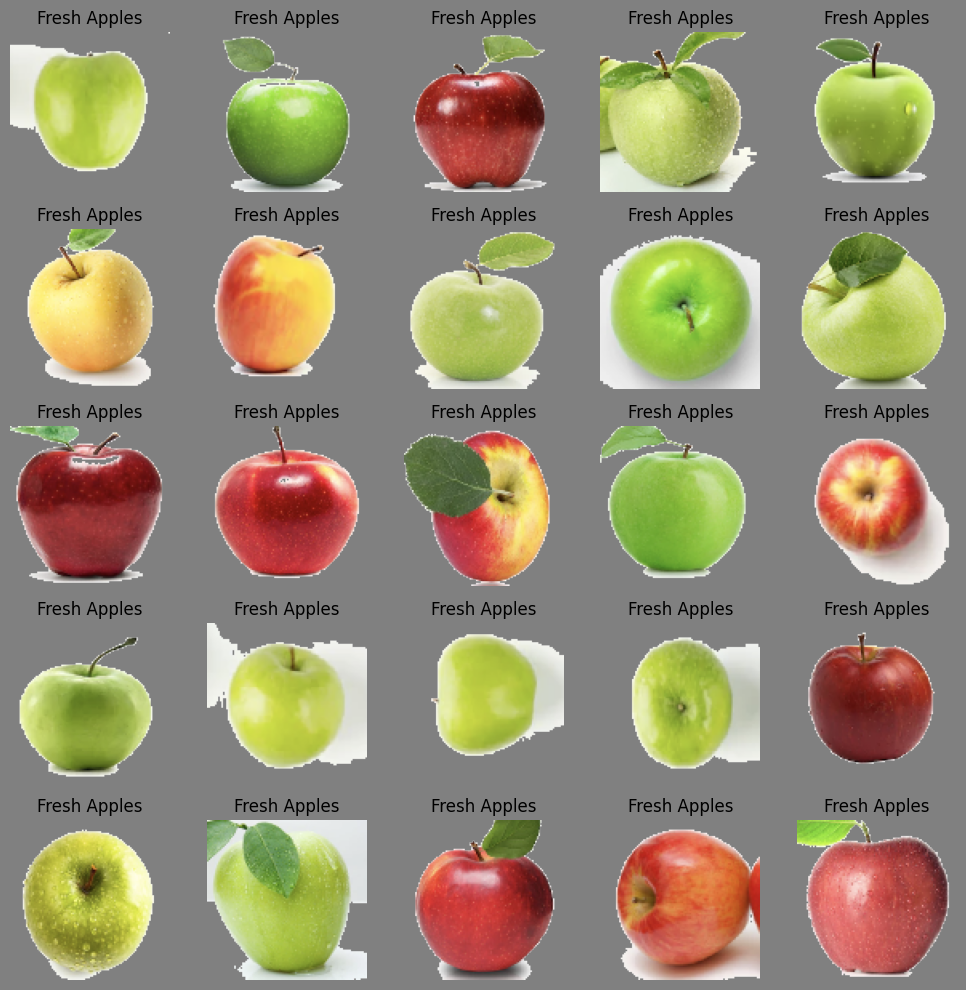

In [ ]:
for generator in [train_generator, test_generator]:
    # Get a batch of images and labels
    sample_images, sample_labels = next(generator)

    # Convert labels to class names
    sample_labels = [include_label[np.argmax(label)] for label in sample_labels if np.argmax(label) < num_label]

    # Visualize the images
    visualize_images(sample_images, sample_labels)

    print("="*100)

## Modelling

Membuat model sekuensial

In [ ]:
# Create model with BatchNormalization to help reduce overfitting
model = Sequential()

# Input Layer + BatchNormalization
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 4)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.5))

# Hidden layer 1
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# Hidden layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# Hidden layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# Output layer
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_label, activation='softmax'))

lr = 0.001
model.compile(
    optimizer=RMSprop(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Membuat callback khusus untuk menghentikan training

In [ ]:
# Callback: Early Stopping
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True
)

# Callback: Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

model_dir = "model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "model.keras")
best_model_path = os.path.join(model_dir, "best_model.keras")

checkpoint_callback = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Custom callback: Time Limit (120 menit)
class TimeLimitCallback(Callback):
    def __init__(self, max_time):
        super(TimeLimitCallback, self).__init__()
        self.max_time = max_time
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        if time.time() - self.start_time > self.max_time:
            self.model.stop_training = True
            print(f"\nTraining stopped after {self.max_time/60:.1f} minutes.")

time_limit_callback = TimeLimitCallback(max_time=120*60)

Menentukan jumlah epoch, langkah per epoch, dan langkah validasi

In [ ]:
epochs = round((train_generator.samples - validation_generator.samples) * 0.025)
steps_per_epoch = (train_generator.samples // batch_size) * 2
validation_steps = (validation_generator.samples // batch_size) * 2

print("Estimated epochs:", epochs) # 166
print("Steps per epoch:", steps_per_epoch) # 68
print("Validation steps", validation_steps) # 16

Estimated epochs: 166
Steps per epoch: 68
Validation steps 16


## Evaluasi dan Visualisasi

Ringkasan model

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 98, 98, 16)          │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 47, 47, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,148,724 (4.38 MB)

 Trainable params: 1,148,724 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

Training model

In [ ]:
# Assuming train_generator and validation_generator are defined elsewhere
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping_callback, time_limit_callback, lr_scheduler, checkpoint_callback]
)

Epoch 1/166
35/68 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 0.3748 - loss: 2.3040

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 1.60087, saving model to model/best_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.4201 - loss: 2.1261 - val_accuracy: 0.6347 - val_loss: 1.6009 - learning_rate: 0.0010
Epoch 2/166
35/68 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.6466 - loss: 1.3720
Epoch 2: val_loss improved from 1.60087 to 1.42549, saving model to model/best_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6568 - loss: 1.3357 - val_accuracy: 0.5429 - val_loss: 1.4255 - learning_rate: 0.0010
Epoch 3/166
35/68 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - accuracy: 0.7325 - loss: 1.0369
Epoch 3: val_loss improved from 1.42549 to 0.87436, saving model to model/best_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.7414 - loss: 1.0075 - val_accuracy: 0.8635 - val_loss: 0.8744 - learning_rate: 0.0010
Epoch 4/166
35/68 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - accuracy: 0.7950 - loss: 0.8335
Epoch 4: val_loss improved from 0.87436 to 0.74773, 

History training model

In [ ]:
print(json.dumps(history.history, indent=4))

{
    "accuracy": [
        0.4681715667247772,
        0.6676072478294373,
        0.7507900595664978,
        0.8080135583877563,
        0.8641083240509033,
        0.8834086060523987,
        0.9084650278091431,
        0.9079006910324097,
        0.9132054448127747,
        0.9243792295455933,
        0.9340857863426208,
        0.9312641024589539,
        0.9391647577285767,
        0.9476298093795776,
        0.943566620349884,
        0.9551918506622314,
        0.9519187211990356,
        0.9498871564865112,
        0.963092565536499,
        0.9521444439888,
        0.9662528038024902,
        0.9558690786361694,
        0.9654627442359924,
        0.960270881652832,
        0.9697517156600952,
        0.9742663502693176,
        0.9625282287597656,
        0.970541775226593,
        0.9735891819000244
    ],
    "loss": [
        1.9374125003814697,
        1.297141671180725,
        0.9762595891952515,
        0.7759110927581787,
        0.5926832556724548,
        0.499233

Melihat akurasi, loss, val akurasi, dan val loss model menggunakan plot

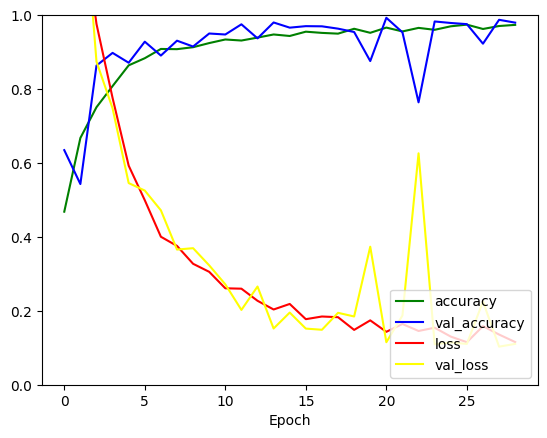

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
plt.plot(history.history['loss'], label='loss', color='red')
plt.plot(history.history['val_loss'], label='val_loss', color='yellow')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Mengevaluasi performa dan memprediksi output model

In [ ]:
model.evaluate(test_generator)
model.predict(test_generator)

16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9814 - loss: 0.1518
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


array([[9.4082254e-01, 5.7676763e-05, 5.9092410e-02, 2.7342181e-05],
       [9.9824959e-01, 3.4285651e-05, 1.7159149e-03, 2.2618137e-07],
       [8.6509335e-01, 6.3425145e-04, 1.3397169e-01, 3.0072872e-04],
       ...,
       [1.0601902e-04, 8.6598142e-05, 8.8032156e-02, 9.1177517e-01],
       [8.0382029e-05, 6.4070651e-04, 7.8039966e-03, 9.9147499e-01],
       [9.6316588e-05, 1.0234081e-03, 1.5864823e-02, 9.8301548e-01]],
      dtype=float32)

Menyimpan model

In [ ]:
model.save(model_path)
print(f"Model disimpan di: {model_path}")

Model disimpan di: model/model.keras


## Konversi Model

Simpan model ke model tflite dan model tfjs yang disimpan

In [ ]:
# Direktori untuk masing-masing format
history_dir = "history"
saved_model_dir = "saved_model"
tflite_dir = "tflite"
tfjs_model_dir = "tfjs_model"

# Buat direktori jika belum ada
[os.makedirs(dir, exist_ok=True) for dir in [history_dir, saved_model_dir, tflite_dir, tfjs_model_dir]]

# 1. Simpan history training
history_path = os.path.join(history_dir, 'history.pkl')
os.makedirs(os.path.dirname(history_path), exist_ok=True)
with open(history_path, 'wb') as f: pickle.dump(history.history, f)

# 2. Simpan model sebagai SavedModel ke direktori saved_model_dir
tf.saved_model.save(model, saved_model_dir)
print("SavedModel disimpan di:", saved_model_dir)

# 3. Konversi model ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Simpan model TF-Lite ke file model.tflite di folder tflite
tflite_model_path = os.path.join(tflite_dir, "model.tflite")
with open(tflite_model_path, "wb") as f: f.write(tflite_model)
print("TF Lite model disimpan di:", tflite_model_path)

# Simpan label atau class gambar ke file label.txt di folder tflite
label_file_path = os.path.join(tflite_dir, "label.txt")
if not os.path.exists(label_file_path):
    with open(label_file_path, "w") as f: f.write("\n".join(include_label))
print("File label disimpan di:", label_file_path)

# 4. Konversi model ke format TensorFlow.js
tfjs_command = f"tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {saved_model_dir} {tfjs_model_dir}"
os.system(tfjs_command)
print("TFJS model disimpan di folder:", tfjs_model_dir)


SavedModel disimpan di: saved_model
Saved artifact at '/tmp/tmpl8xm7co_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 4), dtype=tf.float32, name='keras_tensor_348')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140378989971600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140378989972176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140378989971408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140378989974288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140378989972560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140378989975248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140378989974096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140378989976592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140378989976016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140378989977552: TensorSpec(shape=(), dtype=

In [ ]:
# Load the model history
with open(history_path, 'rb') as file: loaded_history = pickle.load(file)

# Compute statistics for each metric
history_stats = {}
for metric in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
    if metric in loaded_history and loaded_history[metric]:
        values = loaded_history[metric]
        history_stats[metric] = {
            "values": values,
            "max": max(values),
            "min": min(values),
            "mean": sum(values) / len(values),
            "median": sorted(values)[len(values) // 2]
        }

# Save history data to JSON
history_json_path = os.path.join(history_dir, "history.json")
with open(history_json_path, 'w') as json_file: json.dump(history_stats, json_file, indent=4)

# Plot the model history
plt.figure()
plt.plot(loaded_history['accuracy'], label='accuracy', color='green')
plt.plot(loaded_history['val_accuracy'], label='val_accuracy', color='blue')
plt.plot(loaded_history['loss'], label='loss', color='red')
plt.plot(loaded_history['val_loss'], label='val_loss', color='yellow')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Save plot to history_dir
history_plot_path = os.path.join(history_dir, "history_plot.png")
plt.savefig(history_plot_path)
plt.close()

print(f"History saved to: {history_json_path}")
print(f"Plot saved to: {history_plot_path}")

History saved to: history/history.json
Plot saved to: history/history_plot.png


## Inference (Optional)

In [36]:
%pip install IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00


Inference menggunakan tfjs_model

In [61]:
import requests
from IPython.core.display import display, HTML

url = "https://adityadn64.github.io/Dicoding-FP-IC-CD/inference_with_tfjs.html"

# Ambil HTML mentah dari URL
html_content = requests.get(url).content.decode("utf-8")

# print(html_content)

# Tampilkan di Google Colab
display(HTML(html_content))


Additional Information (Dicoding Profile):

- User profile:
 - Full name: Aditya Dwi Nugraha
 - Username: aditya_dwi_10
 - Email: adityadwinugraha.2021@gmail.com

Submission/Project has been completed with all requirements.

Final Project: Image Classification (Klasifikasi Gambar)

Class: Belajar Pengembangan Machine Learning

Image Classification: Fruits

Created by: Aditya Dwi Nugraha

© Copyright 2025 All Right Reserved by Aditya Dwi Nugraha